# Latent Dirichlet Allocation models on BBC data

### Model 1. Scikit-learn

In [1]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import textwrap
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import string
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import PorterStemmer
import spacy
import gensim
import gensim.corpora as corpora
from pprint import pprint
import pyLDAvis.gensim_models as gensimvis
import pickle
import pyLDAvis
import os
from gensim.models import CoherenceModel, TfidfModel
import pyLDAvis.gensim
import re
from bertopic import BERTopic
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
from bertopic.vectorizers import ClassTfidfTransformer
from umap import UMAP
from hdbscan import HDBSCAN


stops = stopwords.words('english')
stops.extend(['has', 'been', 're', 'com', 'edu', 'use', 'said', 'would', 'could', 'told', 'also', 'one', 'two', 'mr', 'new', 'year'])

In [2]:
# Read the data
df = pd.read_csv('bbc_text_cls.csv')

# Remove missing values
df.dropna(axis = 0, how ='any', inplace=True)

# # Add num words column
# df['Num_words_text'] = df['text'].apply(lambda x:len(str(x).split()))
# max_review_data_sentence_length  = df['Num_words_text'].max()

# # Create a mask to filter out long reviews and very short ones
# mask = (df['Num_words_text'] < 100) & (df['Num_words_text'] >=20)
# df = df[mask]

# Remove punctuation
def remove_punctuation(text):
  return text.translate(str.maketrans('', '', string.punctuation))

df['text'] = df['text'].apply(remove_punctuation)

# Remove \n characters
df['text'] = df['text'].str.replace('\n', ' ')

# Remove digits and non-alphanumeric characters
df['text'] = df['text'].str.replace('[^a-zA-Z0-9\s]', '')

# Lowercase the text
df['text'] = df['text'].str.lower()

# Normalize whitespace
def normalize_whitespace(text):
    text = re.sub('[\s]+', ' ', text)
    return text

df['text'] = df['text'].map(normalize_whitespace)

# Remove stopwords
def remove_stopwords(text):
    text = " ".join([word for word in text.split() if word not in stops])
    return text

df['text'] = df['text'].apply(remove_stopwords)

# Lemmatization
def lemmatization(text, allowed_postags = ['NOUN', 'ADJ']):
  doc = nlp(''.join(text))
  doc = [token.lemma_ for token in doc if token.pos_ in allowed_postags]
  return ' '.join(doc)

nlp = spacy.load('en_core_web_sm', disable = ['parser', 'ner'])
df['text'] = df['text'].map(lemmatization)

# Stemming
def stemming(text):
  doc = [PorterStemmer().stem(w).strip() for w in text.split()]
  return ' '.join(doc)

df['text'] = df['text'].map(stemming)

# # Remove words that contain digits - CONSIDER USING THIS ONE VERY CAREFULLY! PROVIDES WORSE RESULTS IN THIS CASE!
# pattern = re.compile(r'\b\w*\d\w*\b')
# df['text'] = df['text'].apply(lambda x: pattern.sub('', x))

# Remove short words
def short_words_removal(text):
  text = text.split()
  text = [word for word in text if len(word) > 2]
  text = ' '.join(text)
  return text

df['text'] = df['text'].map(short_words_removal)

# Normalize whitespace again
df['text'] = df['text'].map(normalize_whitespace)

<>:25: DeprecationWarning: invalid escape sequence \s
<>:32: DeprecationWarning: invalid escape sequence \s
<>:25: DeprecationWarning: invalid escape sequence \s
<>:32: DeprecationWarning: invalid escape sequence \s
C:\Users\User\AppData\Local\Temp\ipykernel_17456\50100065.py:25: DeprecationWarning: invalid escape sequence \s
  df['text'] = df['text'].str.replace('[^a-zA-Z0-9\s]', '')
C:\Users\User\AppData\Local\Temp\ipykernel_17456\50100065.py:32: DeprecationWarning: invalid escape sequence \s
  text = re.sub('[\s]+', ' ', text)


In [3]:
df['labels'].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: labels, dtype: int64

In [4]:
# Create count vectorizer
vectorizer = CountVectorizer(stop_words = list(stops),
                            # min_df = 20,
                            # max_df = 0.2,
                            # max_features = 5000,
                            # ngram_range = (1,3)
                            )
X = vectorizer.fit_transform(df['text'])

# Create an LDA model
num_topics = 5
lda = LatentDirichletAllocation(n_components = num_topics, random_state = 12345, max_iter = 50)
lda.fit(X)

LatentDirichletAllocation(max_iter=50, n_components=5, random_state=12345)

In [5]:
lda.components_

array([[0.2244172 , 0.20000059, 1.19734501, ..., 0.20117568, 0.20191243,
        0.20011087],
       [0.20451748, 0.21905773, 0.20000064, ..., 0.20105079, 0.2000002 ,
        0.20000023],
       [0.20000549, 0.20000225, 0.20000335, ..., 0.2000017 , 0.20000101,
        0.20000128],
       [0.20000239, 0.22381797, 0.2026497 , ..., 0.24968507, 1.19808599,
        1.19974395],
       [1.17105745, 1.15712146, 0.2000013 , ..., 1.14808676, 0.20000038,
        0.20014367]])

In [6]:
# Auxillary plotting function
def plot_top_words(model, feature_names, n_top_words = 10):
  fig, axes = plt.subplots(2, 5, figsize = (30, 15), sharex = True)
  axes = axes.flatten()
  for topic_idx, topic in enumerate(model.components_):
    top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
    top_features = [feature_names[i] for i in top_features_ind]
    weights = topic[top_features_ind]
    
    ax = axes[topic_idx]
    ax.barh(top_features, weights, height = 0.7)
    ax.set_title(f'Topic {topic_idx + 1}', fontdict = {'fontsize': 30})
    ax.invert_yaxis()
    ax.tick_params(axis = 'both', which = 'major', labelsize = 20)
    for i in 'top right left'.split():
      ax.spines[i].set_visible(False)
    fig.suptitle("LDA", fontsize = 40)
  
  plt.subplots_adjust(top = 0.90, bottom = 0.05, wspace = 0.90, hspace = 0.3)
  plt.show()

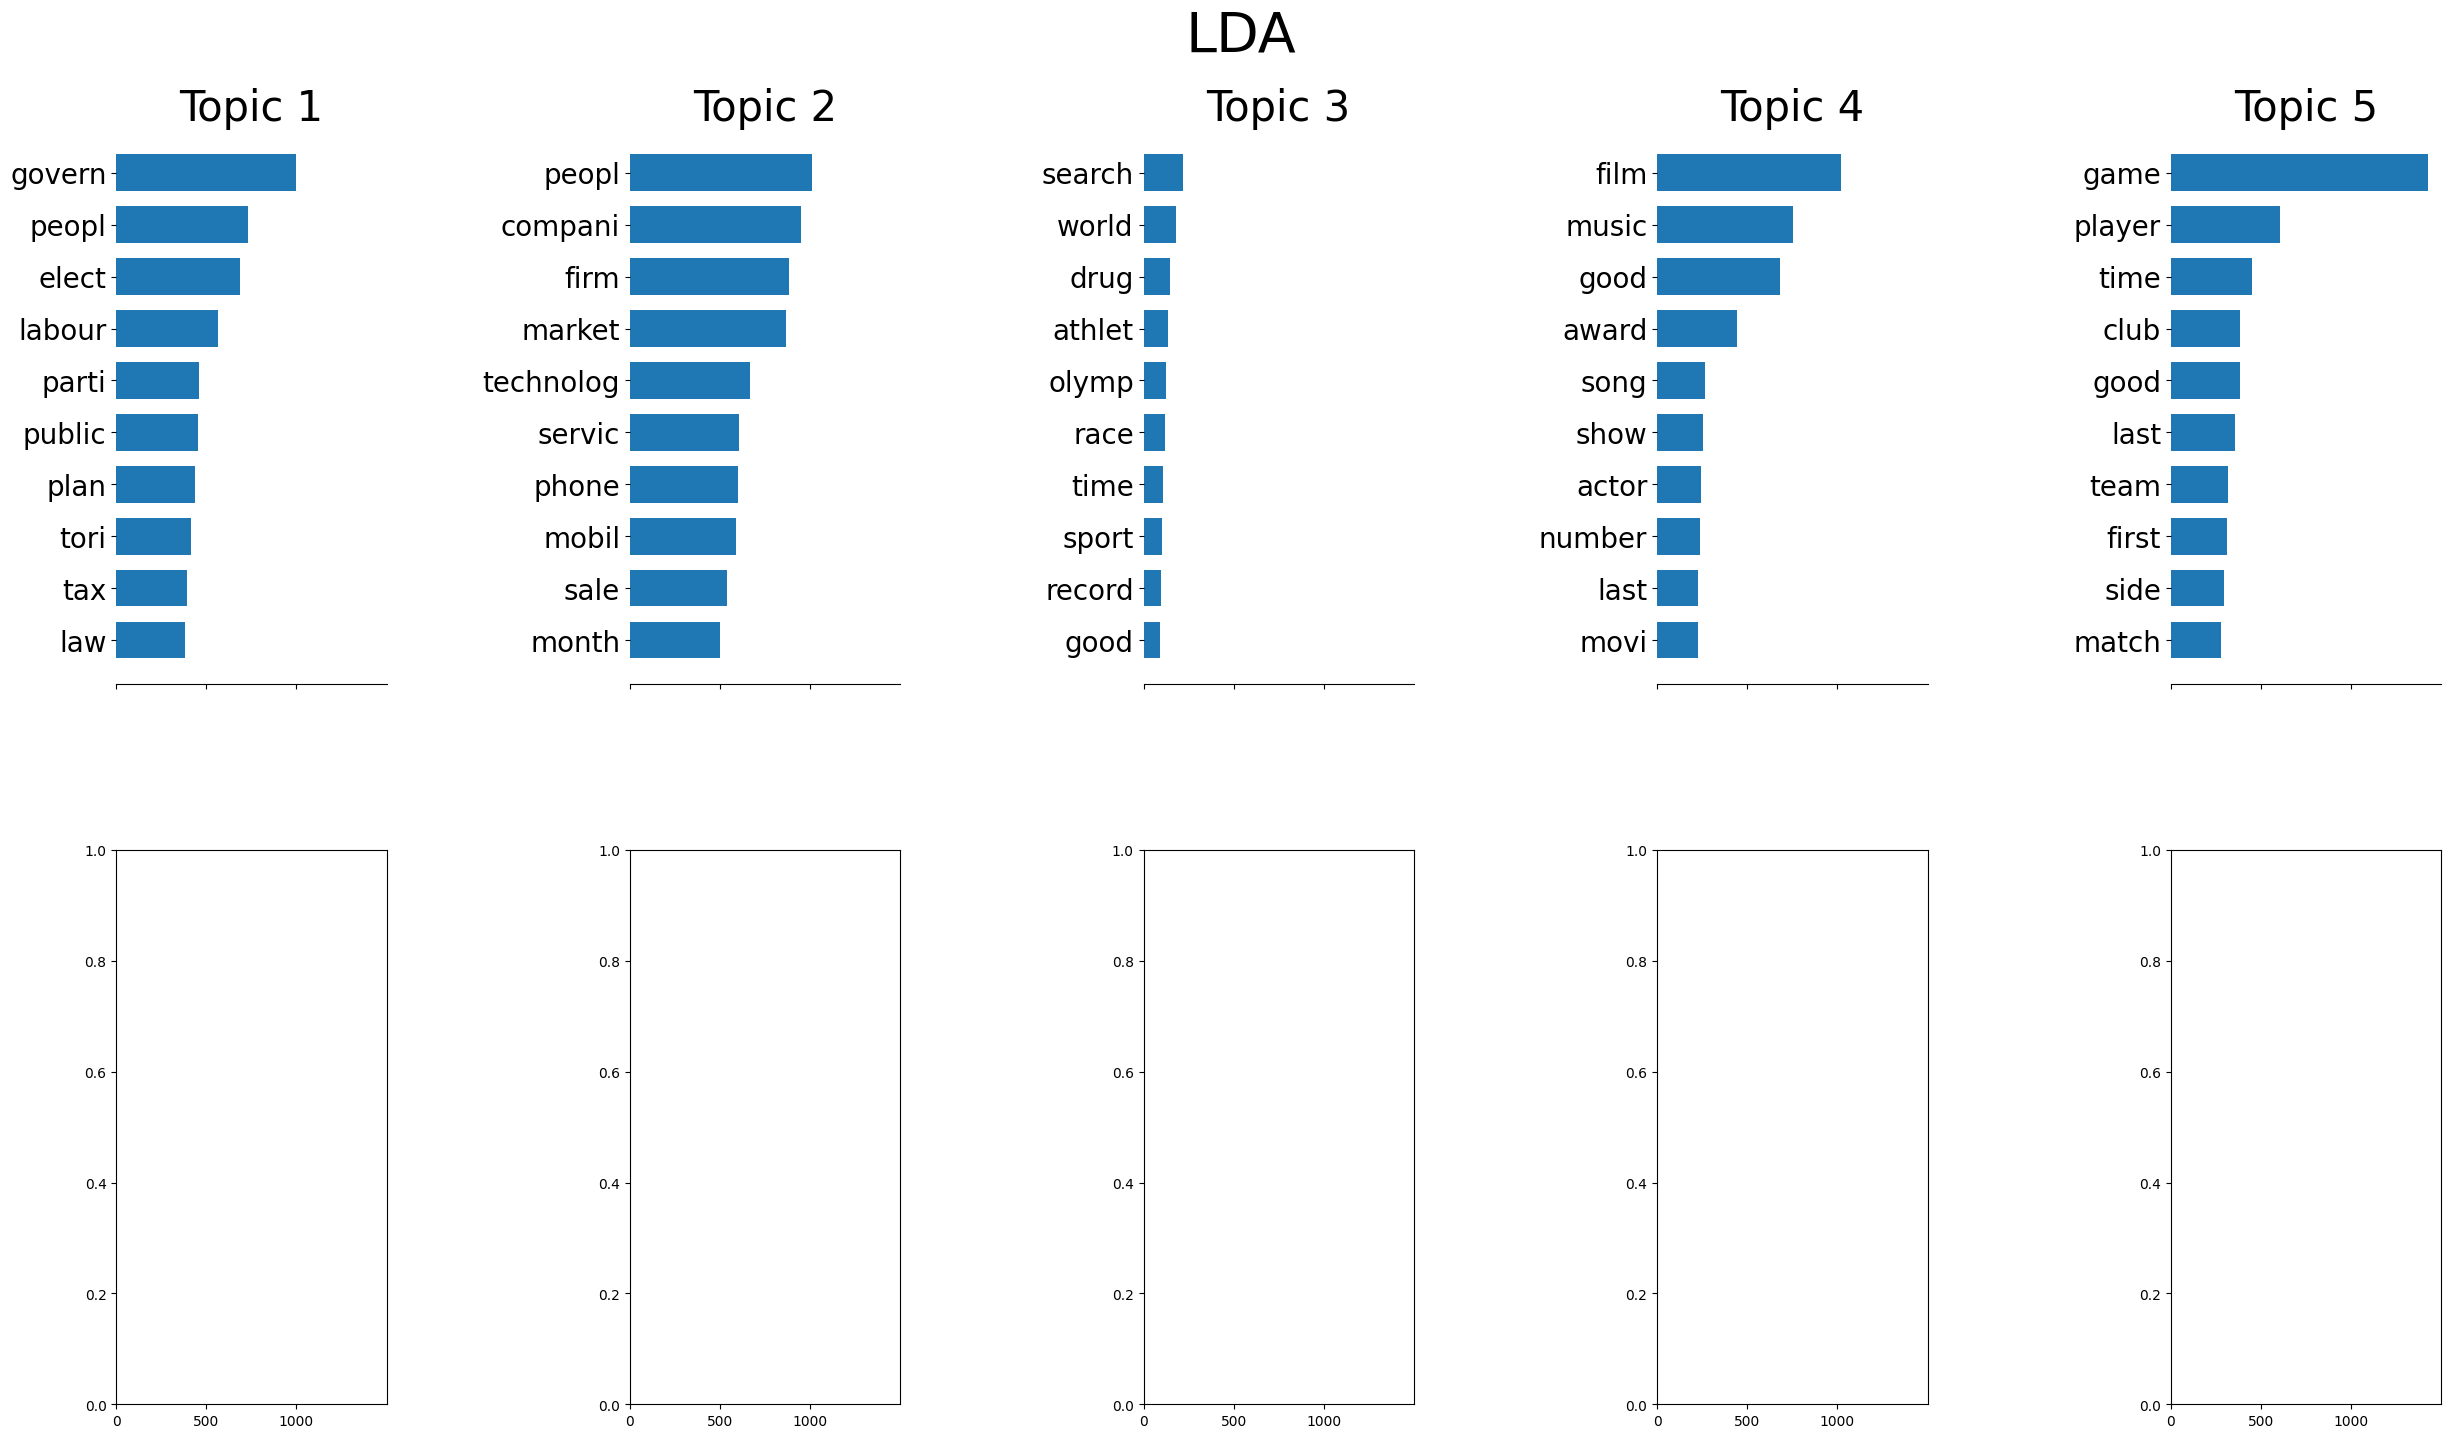

In [7]:
# Words per topics
feature_names = vectorizer.get_feature_names_out()
plot_top_words(lda, feature_names)

In [8]:
# Latent variables extraction
Z = lda.transform(X)

Text(0.5, 1.0, 'True label: sport')

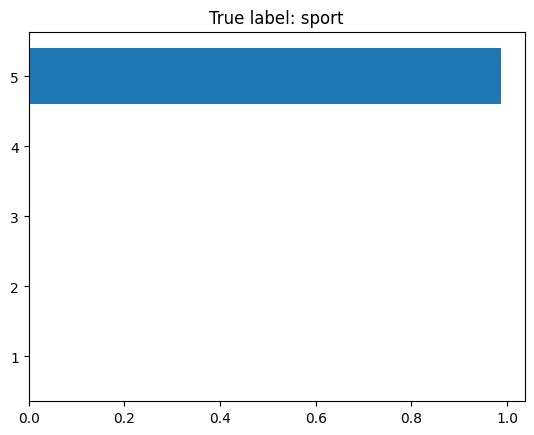

In [9]:
# Sample topic
np.random.seed(0)

i = np.random.choice(len(df))
z = Z[i]
topics = np.arange(num_topics) + 1

fig, ax = plt.subplots()
ax.barh(topics, z)
ax.set_yticks(topics)
ax.set_title('True label: %s' % df.iloc[i]['labels'])

In [10]:
# # Associated article
# def wrap(x):
#   return textwrap.fill(x, replace_whitespace = False, fix_sentence_endings = True)

# print(wrap(df.iloc[i]['text']))

Text(0.5, 1.0, 'True label: entertainment')

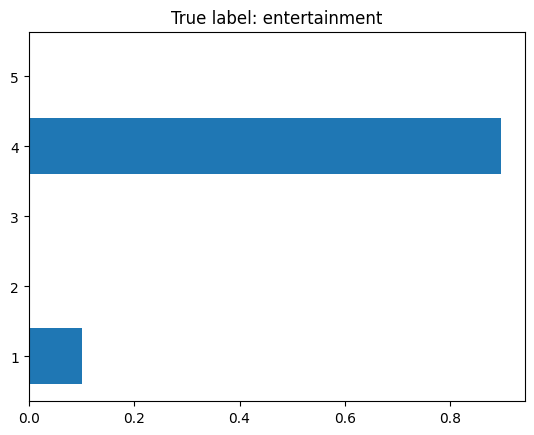

In [11]:
# Sample topic n2
i = np.random.choice(len(df))
z = Z[i]

fig, ax = plt.subplots()
ax.barh(topics, z)
ax.set_yticks(topics)
ax.set_title('True label: %s' % df.iloc[i]['labels'])

In [12]:
# # Associated article n2
# print(wrap(df.iloc[i]['text']))

In [13]:
# Calculating the coherence and perplexity scores
vocab = vectorizer.get_feature_names_out()
words = [nltk.word_tokenize(sentence) for sentence in df['text']]

# Remove words shorter than 3
words_new = []
for word_list in words:
  x = [word for word in word_list if len(word) > 3]
  words_new.append(x)
words = words_new

id2word = corpora.Dictionary(words)

topics = []
for i in range(lda.n_components):
    topic_words = [vocab[j] for j in lda.components_[i].argsort()[:-10 - 1:-1]]
    topics.append(topic_words)


coherence_model_lda = CoherenceModel(topics=topics, texts=words, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
perplexity = np.log(lda.perplexity(X))
log_likelihood = lda.score(X)
print(f'The coherence score is: {round(coherence_lda, 3)}')
print(f'The log perplexity score is: {round(perplexity, 3)}')
print(f'The log likelihood is: {round(log_likelihood, 3)}')

The coherence score is: 0.59
The log perplexity score is: 7.653
The log likelihood is: -1866081.15


In [14]:
def compute_coherence_values(dictionary, words, limit, start=2, step=1):
    coherence_values = []
    model_list = []
    perplexity_list = []
    log_likelihood_scores = []
    
    for num_topics in range(start, limit, step):
        model = LatentDirichletAllocation(n_components = num_topics, max_iter = 100,
#                                          learning_method='online'
                                         )
        model.fit(X) 
        model_list.append(model)
        
        topics = []
        for i in range(model.n_components):
            topic_words = [vocab[j] for j in model.components_[i].argsort()[:-10 - 1:-1]]
            topics.append(topic_words)
        coherencemodel = CoherenceModel(topics=topics, texts=words, dictionary=dictionary, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())
        
        perplexity = np.log(model.perplexity(X))
        perplexity_list.append(perplexity)
        
        log_likelihood = model.score(X)
        log_likelihood_scores.append(log_likelihood)

    return model_list, coherence_values, perplexity_list, log_likelihood_scores
  
model_list, coherence_values, perplexity_list, log_likelihood_scores = compute_coherence_values(dictionary=id2word, words=words, start=2, limit=10, step=1)

Text(0, 0.5, 'Log-likelihood Score')

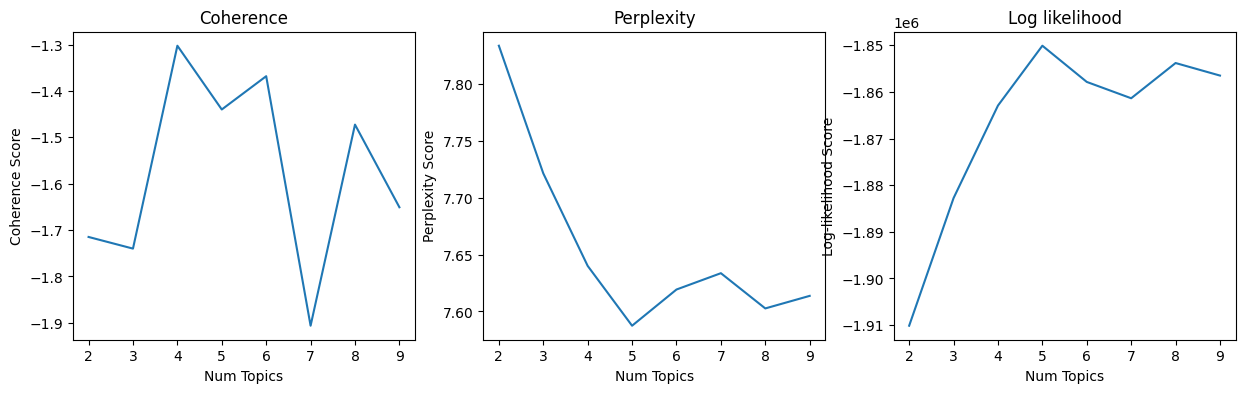

In [15]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

limit=10; start=2; step=1;
x = range(start, limit, step)

axs[0].plot(x, coherence_values)
axs[0].set_title('Coherence')
axs[0].set_xlabel('Num Topics')
axs[0].set_ylabel('Coherence Score')

axs[1].plot(x, perplexity_list)
axs[1].set_title('Perplexity')
axs[1].set_xlabel('Num Topics')
axs[1].set_ylabel('Perplexity Score')

axs[2].plot(x, log_likelihood_scores)
axs[2].set_title('Log likelihood')
axs[2].set_xlabel('Num Topics')
axs[2].set_ylabel('Log-likelihood Score')

### Model 1.1 Sklearn LDA with Tfidf vectorizer.

In [16]:
# Tokenization and 

vectorizer_tf = TfidfVectorizer(stop_words = list(stops), 
                                max_df = 0.8, min_df = 2, 
                                use_idf = False, norm = None)
tf_vectors = vectorizer_tf.fit_transform(df['text'])

In [17]:
# LDA model definition
lda = LatentDirichletAllocation(n_components = 5, max_iter = 5, learning_method = 'online', learning_offset = 50, n_jobs = -1, random_state = 111)

W1 = lda.fit_transform(tf_vectors)
H1 = lda.components_

In [18]:
# Words per topic
num_words = 15

vocab = np.array(vectorizer_tf.get_feature_names_out())

top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_words-1:-1]]
topic_words = ([top_words(t) for t in H1])
topics = [' '.join(t) for t in topic_words]
topics

['peopl govern elect labour plan countri time parti market public last month tori economi rate',
 'peopl mobil phone technolog servic user comput music net network softwar firm digit system mani',
 'law compani court case legal firm oil sale govern right trial drug charg product action',
 'player game club last music good time side first team match second minut week season',
 'game film good time award world last titl peopl day first director actor star life']

In [19]:
# Topic per document probability distribution
colnames = ['Topic' + str(i) for i in range(lda.n_components)]
docnames = ['Doc' + str(i) for i in range(len(df['text']))]
df_doc_topic = pd.DataFrame(np.round(W1, 2), columns = colnames, index = docnames)
df_doc_topic['dominant_topic'] = np.argmax(df_doc_topic.values, axis = 1)
df_doc_topic

,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic
Doc0,0.56,0.22,0.11,0.06,0.05,0
Doc1,0.99,0.00,0.00,0.00,0.00,0
Doc2,0.00,0.00,0.99,0.00,0.00,2
Doc3,0.67,0.00,0.27,0.06,0.00,0
Doc4,0.53,0.00,0.34,0.12,0.00,0
...,...,...,...,...,...,...
Doc2220,0.09,0.88,0.03,0.00,0.00,1
Doc2221,0.00,0.99,0.00,0.00,0.00,1
Doc2222,0.41,0.47,0.12,0.00,0.00,1
Doc2223,0.20,0.79,0.00,0.00,0.00,1


In [20]:
vocab = vectorizer_tf.get_feature_names_out()
words = [nltk.word_tokenize(sentence) for sentence in df['text']]
# Remove words shorter than 3
words_new = []
for word_list in words:
  x = [word for word in word_list if len(word) > 3]
  words_new.append(x)
words = words_new

id2word = corpora.Dictionary(words)


def compute_coherence_values(dictionary, words, limit, start=2, step=1):
    coherence_values = []
    model_list = []
    perplexity_list = []
    log_likelihood_scores = []
    
    for num_topics in range(start, limit, step):
        model = LatentDirichletAllocation(n_components = num_topics, max_iter = 100)
        model.fit(tf_vectors) 
        model_list.append(model)
        
        topics = []
        for i in range(model.n_components):
            topic_words = [vocab[j] for j in model.components_[i].argsort()[:-10 - 1:-1]]
            topics.append(topic_words)
            
        coherencemodel = CoherenceModel(topics=topics, texts=words, dictionary=dictionary, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())
        
        perplexity = np.log(model.perplexity(tf_vectors))
        perplexity_list.append(perplexity)
        
        log_likelihood = model.score(tf_vectors)
        log_likelihood_scores.append(log_likelihood)

    return model_list, coherence_values, perplexity_list, log_likelihood_scores
  
model_list, coherence_values, perplexity_list, log_likelihood_scores = compute_coherence_values(dictionary=id2word, words=words, start=2, limit=10, step=1)

Text(0, 0.5, 'Log-likelihood Score')

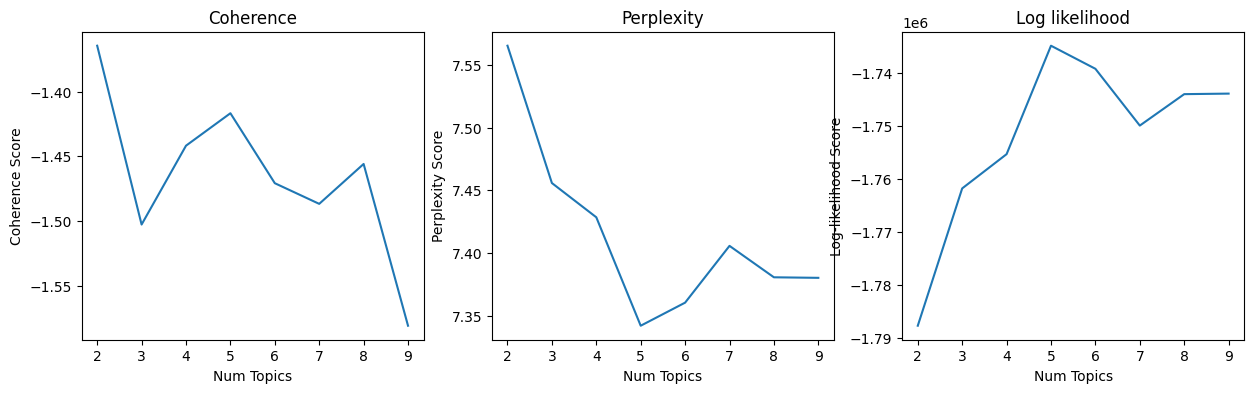

In [21]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

limit=10; start=2; step=1;
x = range(start, limit, step)

axs[0].plot(x, coherence_values)
axs[0].set_title('Coherence')
axs[0].set_xlabel('Num Topics')
axs[0].set_ylabel('Coherence Score')

axs[1].plot(x, perplexity_list)
axs[1].set_title('Perplexity')
axs[1].set_xlabel('Num Topics')
axs[1].set_ylabel('Perplexity Score')

axs[2].plot(x, log_likelihood_scores)
axs[2].set_title('Log likelihood')
axs[2].set_xlabel('Num Topics')
axs[2].set_ylabel('Log-likelihood Score')

### Model 2. LDA with Gensim

In [22]:
# Create document-term matrix
def create_document_term_matrix(dataframe, column_name):
  cv = CountVectorizer(analyzer = 'word')
  data = cv.fit_transform(dataframe[column_name])
  df_dtm = pd.DataFrame(data.toarray(), columns = cv.get_feature_names_out())
  df_dtm.index = dataframe.index
  return df_dtm

df_dtm = create_document_term_matrix(df, 'text')

# Create bigrams and trigrams (note: only one of these will be used for modelling)
words = [nltk.word_tokenize(sentence) for sentence in df['text']]

# # Remove words shorter than 3
# words_new = []
# for word_list in words:
#   x = [word for word in word_list if len(word) > 3]
#   words_new.append(x)
# words = words_new


bigram = gensim.models.Phrases(words, min_count = 5, threshold = 100)
trigram = gensim.models.Phrases(bigram[words], threshold = 100)

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def make_bigrams(texts):
  return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
  return [trigram_mod[bigram_mod[doc]] for doc in texts]

words_bigrams = make_bigrams(words)
words_trigrams = make_trigrams(words)

In [23]:
# id2word dictionary and corpus
id2word = corpora.Dictionary(words)

# OPTIONAL STEP!.
# Filter out tokens that appear in less than 15 documents, more than 0.5 documents (fraction of total corpus size, not absolute number) and keep only the first 100000 most frequent tokens.
# id2word.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

texts = words
corpus = [id2word.doc2bow(text) for text in texts]
vocab = vectorizer.get_feature_names_out()

In [24]:
# LDA model
num_topics = 5

lda_model = gensim.models.LdaMulticore(corpus = corpus, id2word = id2word, num_topics = num_topics, 
#                                        chunksize = 1000,
                                       passes = 50,
                                       iterations = 50,
#                                        per_word_topics = True
                                      )

In [25]:
# Print the most common words per topic
pprint(lda_model.print_topics())

[(0,
  '0.012*"compani" + 0.011*"market" + 0.010*"firm" + 0.009*"sale" + '
  '0.009*"price" + 0.008*"growth" + 0.008*"economi" + 0.007*"rate" + '
  '0.007*"share" + 0.007*"month"'),
 (1,
  '0.017*"peopl" + 0.013*"game" + 0.011*"technolog" + 0.010*"phone" + '
  '0.010*"mobil" + 0.009*"music" + 0.009*"servic" + 0.008*"user" + '
  '0.008*"comput" + 0.006*"network"'),
 (2,
  '0.014*"govern" + 0.013*"peopl" + 0.012*"elect" + 0.009*"labour" + '
  '0.008*"parti" + 0.007*"public" + 0.007*"tori" + 0.007*"plan" + '
  '0.006*"minist" + 0.006*"issu"'),
 (3,
  '0.026*"film" + 0.021*"good" + 0.012*"award" + 0.011*"music" + 0.011*"year" '
  '+ 0.007*"last" + 0.007*"actor" + 0.006*"show" + 0.006*"star" + '
  '0.006*"song"'),
 (4,
  '0.019*"game" + 0.013*"player" + 0.010*"time" + 0.010*"club" + 0.009*"good" '
  '+ 0.009*"team" + 0.008*"last" + 0.008*"side" + 0.007*"first" + '
  '0.007*"match"')]


In [26]:
# Model results evaluation + model visualization html file

pyLDAvis.enable_notebook()
model_filepath = 'LDA_Model_' + str(num_topics)

LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
with open(model_filepath, 'wb') as f:
  pickle.dump(LDAvis_prepared, f)
  
with open(model_filepath, 'rb') as f:
  LDAvis_prepared = pickle.load(f)
  
pyLDAvis.save_html(LDAvis_prepared, 'LDAvis_prepared_' + str(num_topics) + '.html')

LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.084492  0.062601       1        1  24.396186
1      0.070507 -0.161348       2        1  23.719070
0      0.152531  0.054215       3        1  21.645469
4     -0.132608  0.132512       4        1  15.802442
3     -0.174922 -0.087980       5        1  14.436834, topic_info=       Term         Freq        Total Category  logprob  loglift
26     film   953.000000   953.000000  Default  30.0000  30.0000
809    game  1398.000000  1398.000000  Default  29.0000  29.0000
119  govern  1112.000000  1112.000000  Default  28.0000  28.0000
53    music   862.000000   862.000000  Default  27.0000  27.0000
340   elect   659.000000   659.000000  Default  26.0000  26.0000
..      ...          ...          ...      ...      ...      ...
80     time   190.262581  1309.392639   Topic5  -5.1618   0.0065
346   first   169.902410   834.156429   Topic5  -5.2750   0.3442
256   world   172.063573   889.382692   Topic5  -5.2623   0.2927
589    titl   124.562591   269.412241   Topic5  -5.5854   1.1640
478    week   129.517364   737.518255   Topic5  -5.5464   0.1959

[364 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
4309      2  0.008839     actor
4309      5  0.989978     actor
5146      5  0.990268   actress
207       3  0.960601  aircraft
208       1  0.007825    airlin
...     ...       ...       ...
365       1  0.160625      year
365       2  0.125895      year
365       3  0.245712      year
365       4  0.158888      year
365       5  0.309094      year

[777 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1, 5, 4])

In [27]:
# Calculate perplexity
perplexity = lda_model.log_perplexity(corpus)
perplexity

-7.557682620207395

In [28]:
# Model evaluation with Coherence Score
coherence_model_lda = CoherenceModel(model = lda_model, texts = words, dictionary = id2word, coherence='c_v')

coherence_lda = coherence_model_lda.get_coherence()

print(coherence_lda)

0.5494806110313026


In [29]:
def compute_coherence_values(id2word, corpus, words, limit, start=2, step=1):
    coherence_values = []
    model_list = []
    perplexity_list = []
    
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics,
                                       passes = 100,
                                       iterations = 100,
#                                        per_word_topics = True,
#                                        alpha = 1,
#                                        eta = 0.8
                                      )
        model_list.append(model)
        
#         topics = []
#         for i in range(model.num_topics):
#             topic_words = [vocab[j] for j in model.get_topics()[i].argsort()[:-10 - 1:-1]]
#             topics.append(topic_words)
        
        
        coherencemodel = CoherenceModel(model=model, texts=words, dictionary=id2word, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())
        
        perplexity = model.log_perplexity(corpus)
        perplexity_list.append(perplexity)

    return model_list, coherence_values, perplexity_list
  
model_list, coherence_values, perplexity_list = compute_coherence_values(id2word=id2word, corpus=corpus, words=words, start=2, limit=10, step=1)

KeyboardInterrupt: 

In [ ]:
# Show graph
limit=10; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

In [ ]:
# Show graph
limit=10; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, perplexity_list)
plt.xlabel("Num Topics")
plt.ylabel("Perplexity score")
plt.legend(("perplexity_values"), loc='best')
plt.show()

# Print the perplexity scores
for m, cv in zip(x, perplexity_list):
    print("Num Topics =", m, " has Perplexity Value of", round(cv, 4))

In [ ]:
best_num = 4

# Select the model and print the topics
optimal_model = model_list[best_num-2]
model_topics = optimal_model.show_topics(formatted=False)
optimal_model.print_topics(num_words=10)

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)
vis

### Model 2.1 LDA with Gensim model with TF-IDF (alternative approach)

In [ ]:
tfidf = TfidfModel(corpus=corpus, id2word = id2word, normalize = False)
corpus_tfidf = tfidf[corpus]

In [ ]:
# LDA model
num_topics = 5

lda_model = gensim.models.LdaMulticore(corpus = corpus_tfidf, id2word = id2word, num_topics = num_topics, 
                                       chunksize = 1000,
                                       passes = 50,
                                       iterations = 50,
                                       per_word_topics = True
                                      )

In [ ]:
# Print the most common words per topic
pprint(lda_model.print_topics())

In [ ]:
# Model results evaluation + model visualization html file

pyLDAvis.enable_notebook()
model_filepath = 'LDA_Model_' + str(num_topics)

LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus_tfidf, id2word)
with open(model_filepath, 'wb') as f:
  pickle.dump(LDAvis_prepared, f)
  
with open(model_filepath, 'rb') as f:
  LDAvis_prepared = pickle.load(f)
  
pyLDAvis.save_html(LDAvis_prepared, 'LDAvis_prepared_' + str(num_topics) + '.html')

LDAvis_prepared

### Model 3. BERTopic

In [ ]:

# OPTIONAL CODE! MODEL COMPONENTS EXAMPLES
# ----------------------------------------------------------------------------------------

# embedding_model_1 = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2')
# embedding_model_2 = SentenceTransformer('allenai-specter')
# umap_model_1 = PCA(n_components = 5)
# umap_model_2 = UMAP(n_neighbors = 15, n_components = 5, min_dist = 0.0, metric = 'cosine', random_state = 100)
# cluster_model_1 = KMeans(n_clusters = 50)
# cluster_model_2 = HDBSCAN(min_cluster_size=80, min_samples=40, metric = 'euclidean', gen_min_span_tree=True, prediction_data=True)
# vectorizer_model_1 = CountVectorizer(ngram_range = (1,3), stop_words = 'english')
# ctfidf_model_1 = ClassTfidfTransformer(bm25_weighting = True)



# topic_model = BERTopic(
#   umap_model = (umap_model_1, umap_model_2),
#                        embedding_model = (embedding_model_1, embedding_model_2),
#                        hdbscan_model = (cluster_model_1, cluster_model_2),
#                        vectorizer_model = (vectorizer_model_1),
#                        ctfidf_model = (ctfidf_model_1),
#                        calculate_probabilities = True,
#                        verbose = True,
#                        language = 'english')

# ----------------------------------------------------------------------------------------




# OPTIONAL CODE! PICKING THE BESE SENTENCE ENCODER MODEL
# ----------------------------------------------------------------------------------------

# Model initialization, hyperparameters and fitting
# models_list = ['all-mpnet-base-v2', 
#                'multi-qa-mpnet-base-dot-v1',
#                'all-distilroberta-v1',
#                'all-MiniLM-L12-v2',
#                'multi-qa-distilbert-cos-v1',
#                'all-MiniLM-L6-v2',
#                'multi-qa-MiniLM-L6-cos-v1',
#                'paraphrase-multilingual-mpnet-base-v2',
#                'paraphrase-albert-small-v2',
#                'paraphrase-multilingual-MiniLM-L12-v2',
#                'paraphrase-MiniLM-L3-v2',
#                'distiluse-base-multilingual-cased-v2']
# df_list = []
# topics_list = []
# probs_list = []

# for embedding_model in models_list:
#   topic_model = BERTopic(embedding_model = embedding_model, calculate_probabilities = True, n_gram_range = (1,2))
#   topics, probs = topic_model.fit_transform(df['text'])
#   topic_model.reduce_topics(df['text'], nr_topics = 6)
#   df_list.append(topic_model.get_topic_info())
  
#   print(f'Model: {embedding_model}')
#   print(topic_model.get_topic_info())
#   print('\n')
#   print('\n')

# ----------------------------------------------------------------------------------------




# OPTIONAL CODE! UMAP HYPERPARAMETER TUNING
# ----------------------------------------------------------------------------------------

# nn_list = [5, 10, 15, 20, 25]
# n_comp_list = [2, 3, 4, 5, 6, 7]
# metrics = ['cosine', 'euclidean']

# results_list = []

# for n_neighbors in nn_list:
#   for n_components in n_comp_list:
#     for metric in metrics:
#       umap_model = UMAP(n_neighbors = n_neighbors, n_components = n_components, metric = metric)

#       topic_model = BERTopic(embedding_model = 'multi-qa-distilbert-cos-v1', calculate_probabilities = True, umap_model = umap_model)
#       topics, probs = topic_model.fit_transform(df['text'])
#       topic_model.reduce_topics(df['text'], nr_topics = 6)
      
#       print(f'n_neighbors: {n_neighbors}, n_components: {n_components}, metric: {metric}')
#       print(topic_model.get_topic_info())
#       print('\n')
      
#       results_list.append(([n_neighbors, n_components, metric], topic_model.get_topic_info()))
# ----------------------------------------------------------------------------------------



# OPTIONAL CODE! HDBSCAN HYPERPARAMETER TUNING
# ----------------------------------------------------------------------------------------

# cluster_model = HDBSCAN(min_cluster_size=80, min_samples=40, metric = 'euclidean', gen_min_span_tree=True, prediction_data=True)


# min_cluster_size_list = [10, 30, 50, 70, 90]
# min_samples_list = [30, 40, 50]
# metric_list = ['euclidean']

# results_list = []

# for min_cluster_size in min_cluster_size_list:
#   for min_samples in min_samples_list:
#     for metric in metric_list:
#       hdbscan_model = HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, metric = metric, prediction_data=True)

#       topic_model = BERTopic(embedding_model = 'multi-qa-distilbert-cos-v1', calculate_probabilities = True, hdbscan_model = hdbscan_model)
#       topics, probs = topic_model.fit_transform(df['text'])
#       topic_model.reduce_topics(df['text'], nr_topics = 6)
      
#       print(f'min_cluster_size: {min_cluster_size}, min_samples: {min_samples}, metric: {metric}')
#       print(topic_model.get_topic_info())
#       print('\n')
      
#       results_list.append(([min_cluster_size, min_samples, metric], topic_model.get_topic_info()))
      
# ----------------------------------------------------------------------------------------


In [ ]:
topic_model = BERTopic(calculate_probabilities = True, top_n_words = 5, n_gram_range = (1,2), nr_topics = 6)
topics, probs = topic_model.fit_transform(df['text'])
# topic_model.reduce_topics(df['text'])

In [ ]:
# Number of topics, top words by topic and outliers
topic_model.get_topic_info()

In [ ]:
df['labels'].value_counts()

In [ ]:
# Most common words for a particular topic
topic_number = -1
topic_model.get_topic(topic_number)

In [ ]:
# Documents that represent a particular topic the most
topic_number = -1
topic_model.get_representative_docs(topic_number)

In [ ]:
# Topic assignment for the training set
assigned_topics_df = pd.DataFrame({'topic':topics, 'document': df['text']})
assigned_topics_df

In [ ]:
# Most common words per topic barchart visualization
topic_model.visualize_barchart(top_n_topics = 8)

In [ ]:
# Intertopic distance map and topic relations
topic_model.visualize_topics()

In [ ]:
# Topic heatmap that represents how much different topics overlap
topic_model.visualize_heatmap(n_clusters = 6)

In [ ]:
# Hierarchical clustering per topic and related similarities
topic_model.visualize_hierarchy()

In [ ]:
# Topic probability distribution
doc_number = 0
topic_model.visualize_distribution(probs[doc_number])

In [ ]:
# New document classification, most similar topics and the corresponding most common words
new_doc = 'This is my new document about sport'

num_of_topics = 3
similar_topics, similarity = topic_model.find_topics(new_doc, top_n = num_of_topics)

print(f'The top {num_of_topics} similar topics are {similar_topics}, and the similarities are {np.round(similarity, 2)}')

for i in range(num_of_topics):
  print(f'The top keywords for topic {similar_topics[i]} are:')
  print(topic_model.get_topic(similar_topics[i]))

In [ ]:
# Topic similarities
similar_topics, similarity = topic_model.find_topics('gymnastics', top_n = 3)

for sim_topic in similar_topics:
  print(sim_topic)
  print(topic_model.get_topic(sim_topic))

In [ ]:
# Topic labelling formatting and custom labels
topic_labels = topic_model.generate_topic_labels(nr_words = 3, 
                                                 topic_prefix = False,
                                                 word_length = 15,
                                                 separator = ' - ')
topic_model.set_topic_labels(topic_labels)
topic_model.set_topic_labels({0: 'Politics', 8: 'Sports'})
topic_model.get_topic_info().head(10)

In [ ]:
# EXTRA METHODS

# Change n-grams without re-fitting our entire model
topic_model.update_topics(df['text'], n_gram_range=(1,3))

# Merge specific topics
topic_model.merge_topics(df['text'], topics_to_merge = [1, 8, 12])

# Reduce the number of topics by iteratively merging them
topic_model.reduce_topics(df['text'], nr_topics = 5)

In [ ]:
# Document clusters visualization per topic
topic_model.visualize_documents(df['text'],
                               topics = list(range(10)),
                               custom_labels = True,
                               height = 600)

In [ ]:
!git push

#### Things to try to improve LDA:
* Try changing hyperparameters of LDA algorithm
* Try reducing/increasing the number of POS tags
* Try different stemmers/lemmatizers
* Try removing/leaving digits or even more radical - remove words containing numbers
* Try with/without stemming
* Try different alpha/beta parameters of LDA
* Try removing words with len < 2 or 3
* To choose the right number of topics for LDA compare the goodness of fit for various

#### LDA Parameters
* chunksize - Increasing chunksize will speed up training, at least as long as the chunk of documents easily fit into memory.
* passes/iterations - It is important to set the number of “passes” and “iterations” high enough.
* 2 Dirichlet hyperparameters: alpha and beta (or sometimes eta) - try arranging those as follows list(np.arange(0.01, 1, 0.3))  and try different params from there.
* To test different combinations of hyperparameters use nested for loops.

#### Things to try to improve BERTopic
* Try using different ngram ranges
* Reduce the number of topics
* Merge topics
* Specify the topics that you want to find using domain knowledge
* Try using topic_model.visualize_term_rank(log_scale = True/False) to determine the minimum number of words to represent a topic properly.
* It might be a good idea to do some basic preprocessing, such as removing stopwords and lemmatization/stemming
* Try hyperparameter tuning on the UMAP model
* Try hyperparameter tuning on the HDBscan model

#### BERTopic parameters
* embedding_model = 'all-miniLM-L6-v2' or 'paraphrase-MiniLM-L12-v2'. In fact, this is an important parameter that you can adjust simply by picking a model from https://sbert.net/docs/pretrained_models.html Have a look at the speed and performance of each model and adjust to your needs.
* min_topic_size - minimum number of docs per topic to create a new topic category


In [ ]:
df['text']

In [ ]:
def long_words_removal(text):
  text = text.split()
  text = [word for word in text if len(word) > 2]
  text = ' '.join(text)
  return text

df['text'] = df['text'].map(long_words_removal)

In [ ]:
df['text'] = df['text'].map(long_words_removal)

In [ ]:
!gi